Here I train a model on synthetic data without noise generated with an assumption that there is no cavity linewidth effect on the microwave transitions. I will try a fully-connected neural network (FCNN) and a convolutional neural network (CNN).

Import libraries

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load datasets. X is the DR signal vs microwave frequency. Y corresponds to the parallel and normal components of the DC field. Y-data is already normalized.

In [2]:
X_train = np.load("..\Data\X_train1.npy")
Y_train = np.load('..\Data\Y_train1.npy')

X_val = np.load('..\Data\X_val1.npy')
Y_val = np.load('..\Data\Y_val1.npy')

Normalize data, so the DR signal is between zero and one.

In [3]:
Level = np.min(X_train)
Height = np.max(X_train)-np.min(X_train)

X_train = (X_train-Level)/Height
X_val = (X_val - Level) / Height

Plot normalized data

Text(0, 0.5, 'DR signal')

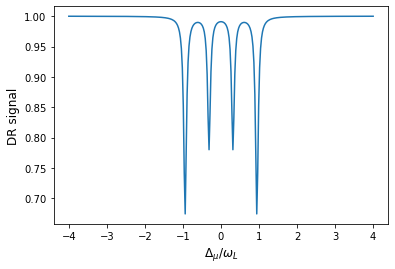

In [4]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-4,4,320), X_train[50])
ax.set_xlabel(r'$\Delta_{\mu}/\omega_{L}$', fontsize=12)
ax.set_ylabel('DR signal', fontsize=12)

Shuffle training and validation sets


In [5]:
m_train = np.random.permutation(len(X_train)) # Shuffling mask for training data
m_test = np.random.permutation(len(X_val)) # Shuffling mask for validation data
X_train, Y_train = X_train[m_train], Y_train[m_train]
X_val, Y_val = X_val[m_test], Y_val[m_test]

# FCNN

Create model

In [6]:
model_fc = keras.models.Sequential([
    keras.layers.Dense(320, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)
])
model_fc.compile(loss="mae", optimizer = keras.optimizers.Adam(), metrics = 'mae')

Create callbacks

In [7]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_mae', restore_best_weights=True) #stop if val_mae is not improving
learning_rate_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=100) # Change learning rate is validation loss is not improving

cb_list = [early_stopping_cb, learning_rate_cb]

Train model

In [8]:
history_fc = model_fc.fit(X_train, Y_train, epochs=2000, validation_data=(X_val, Y_val), batch_size=32, callbacks=cb_list, verbose=False)

Plot results

7/7 [==============================] - 0s 1ms/step
max error: 0.06635508686304092
mean absolute error: 0.0017121118651227806


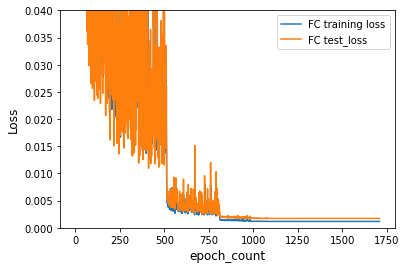

In [9]:
h_fc = history_fc.history

FC_training_data = pd.DataFrame({"FC training loss" : h_fc["loss"], "FC test_loss" :  h_fc["val_loss"]})
FC_training_data.index.name = 'FC Epoch'

fig_fc = FC_training_data.plot()
fig_fc.set_xlabel(r'epoch_count',fontsize=12)
fig_fc.set_ylabel(r'Loss',fontsize=12)
fig_fc.set_ylim(0, 0.04)

y = model_fc.predict(X_val)
print('max error:', np.max(np.abs(y - Y_val)))
print('mean absolute error:', np.mean(np.sqrt((y - Y_val) ** 2)))

# CNN

Create model

In [10]:
model_cnn = keras.models.Sequential([
    keras.layers.Conv1D(kernel_size=16, activation='relu',padding='SAME',filters=32),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(kernel_size=8, activation='relu',padding='SAME',filters=64),
    keras.layers.Conv1D(kernel_size=8, activation='relu',padding='SAME',filters=64),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(kernel_size=4, activation='relu',padding='SAME',filters=128),
    keras.layers.Conv1D(kernel_size=4, activation='relu',padding='SAME',filters=128),
    keras.layers.Flatten(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(2)
])

model_cnn.compile(loss="mae", optimizer = keras.optimizers.Adam(),metrics=["mae"])#loss functions are given for two output neurons

Reshape data for CNN input

In [11]:
X_train_cnn = X_train[:,:,np.newaxis]
X_test_cnn = X_val[:, :, np.newaxis]

Train

In [12]:
history_cnn = model_cnn.fit(X_train_cnn, Y_train, epochs=2000, validation_data=(X_test_cnn, Y_val), batch_size=32, callbacks=cb_list, verbose=False)

Plot

7/7 [==============================] - 0s 2ms/step
max error: 0.03265637904405594
mean absolute error: 0.0006628028866314733


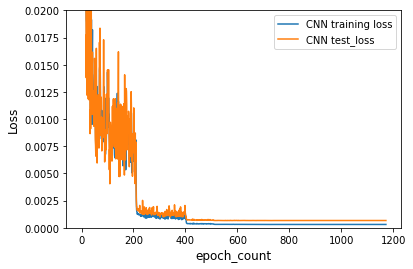

In [13]:
h_cnn = history_cnn.history

cnn_training_data = pd.DataFrame({"CNN training loss" : h_cnn["loss"], "CNN test_loss" :  h_cnn["val_loss"]})
cnn_training_data.index.name = 'CNN Epoch'

fig_cnn = cnn_training_data.plot()
fig_cnn.set_xlabel(r'epoch_count',fontsize=12)
fig_cnn.set_ylabel(r'Loss',fontsize=12)
fig_cnn.set_ylim(0, 0.02)

y = model_cnn.predict(X_test_cnn)
print('max error:', np.max(np.abs(y - Y_val)))
print('mean absolute error:', np.mean(np.sqrt((y - Y_val) ** 2)))

Save model

In [14]:
model_cnn.save('model_pretrained.h5')